# Farms

The eco simulator supports the entire range of farm's functionality, including banks and IMF loans. In this document, we cover the following functionalities of the eco simulator:
1. Compound transactions (selling some defense/farms to buy more expensive defense/farms)
2. Banks & IMF Loans
3. Determining optimal eco'ing under a farm flowchart

In [1]:
import b2sim as b2
import copy

## The Round 23 Monkey Wall Street (Compound Transactions)

With the recent buff to red eco, late game strats are now more viable, and a staple of good farming is the ability to buy a Monkey Wall Street reasonably early enough in the game to get a good return from it. Let's start at Round 20, where we assume the player has access to the following farms:

| Build Item | Current Amount |
|------------|----------------|
| 320 farm   |       2        |
| 204 farm   |       1        |

Our goal is to build a second 204 farm and then sell into a 205 Monkey Wall Street. Note that it is important to specify for our starting farms that they were bought *strictly* before round 20. A farm that is bought exactly on a round start will not give a payout on that round's start. First, we declare the rounds class. I'm going to assume that Round 20 is more anti-stalled than the subsequent rounds in the game.

In [2]:
rounds = b2.Rounds([(0,0.5), (20,0.25),(21,0.5)]) #Set the stall factor to 0.5 for all rounds except round 20.

farms = [
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(19.9), upgrades = [2,0,4]),
]

Next, we set the buy queue. Let me make some comments here about the simulator:
1. Notice that all the actions regarding selling into MWS are placed into one item. This is because I do not want to sell my farms until I absolutely have enough cash to buy the MWS upgrade. When multiple actions are placed into one item in the buy queue, the simulator does not proceed with actions given until it is possible to do *all* of them.
2. The parameter `buffer` specifiies that I don't want to perform the action until I have the amount of cash the action costs *plus* the specified buffer amount. This is useful if you want to sustain eco'ing through transactions.
3. The parameter `min_buy_time` specifies that I don't want to perform the action until I have reached the specified time in the game simulation. For our MWS buy this is useful since I don't want to buy it until *right* before the end of the round. 

In [3]:
buy_queue = [

    #Buy a 204 farm
    [b2.buyFarm(buffer = 250)],
    [b2.upgradeFarm(3,0, buffer = 250)],
    [b2.upgradeFarm(3,0, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],
    [b2.upgradeFarm(3,2, buffer = 250)],

    #As soon as we can afford to do so, sell the first three farms, and upgrade the 4th one to a Monkey Wall Street
    [b2.sellFarm(0), b2.sellFarm(1), b2.sellFarm(2), b2.upgradeFarm(3,2, min_buy_time = rounds.getTimeFromRound(24) - 1)]
]

While progressing through the flowchart, we may find it ideal to improve our eco while doing so. The motivation here is that it's not useful for us to buy MWS until the end of a given round, meaning that, even if it delays when we obtain our Monkey Wall Street, eco'ing is *okay* so long as we don't delay buying MWS until the next round!

In [4]:
eco_queue = [
        b2.ecoSend(rounds.getTimeFromRound(22.5), 'Zero')
]

We are now ready to declare the initial game state and simulate:

,Revenue,Expenses,Profit,Eco Impact
Farm Index,,,,
0,7070.0,0,7070.0,415.0
1,7070.0,0,7070.0,415.0
2,26040.0,0,26040.0,1527.0
3,14640.0,64350,-49710.0,851.0


The current cash and eco are (14946.000000000342,2720.0000000000273)


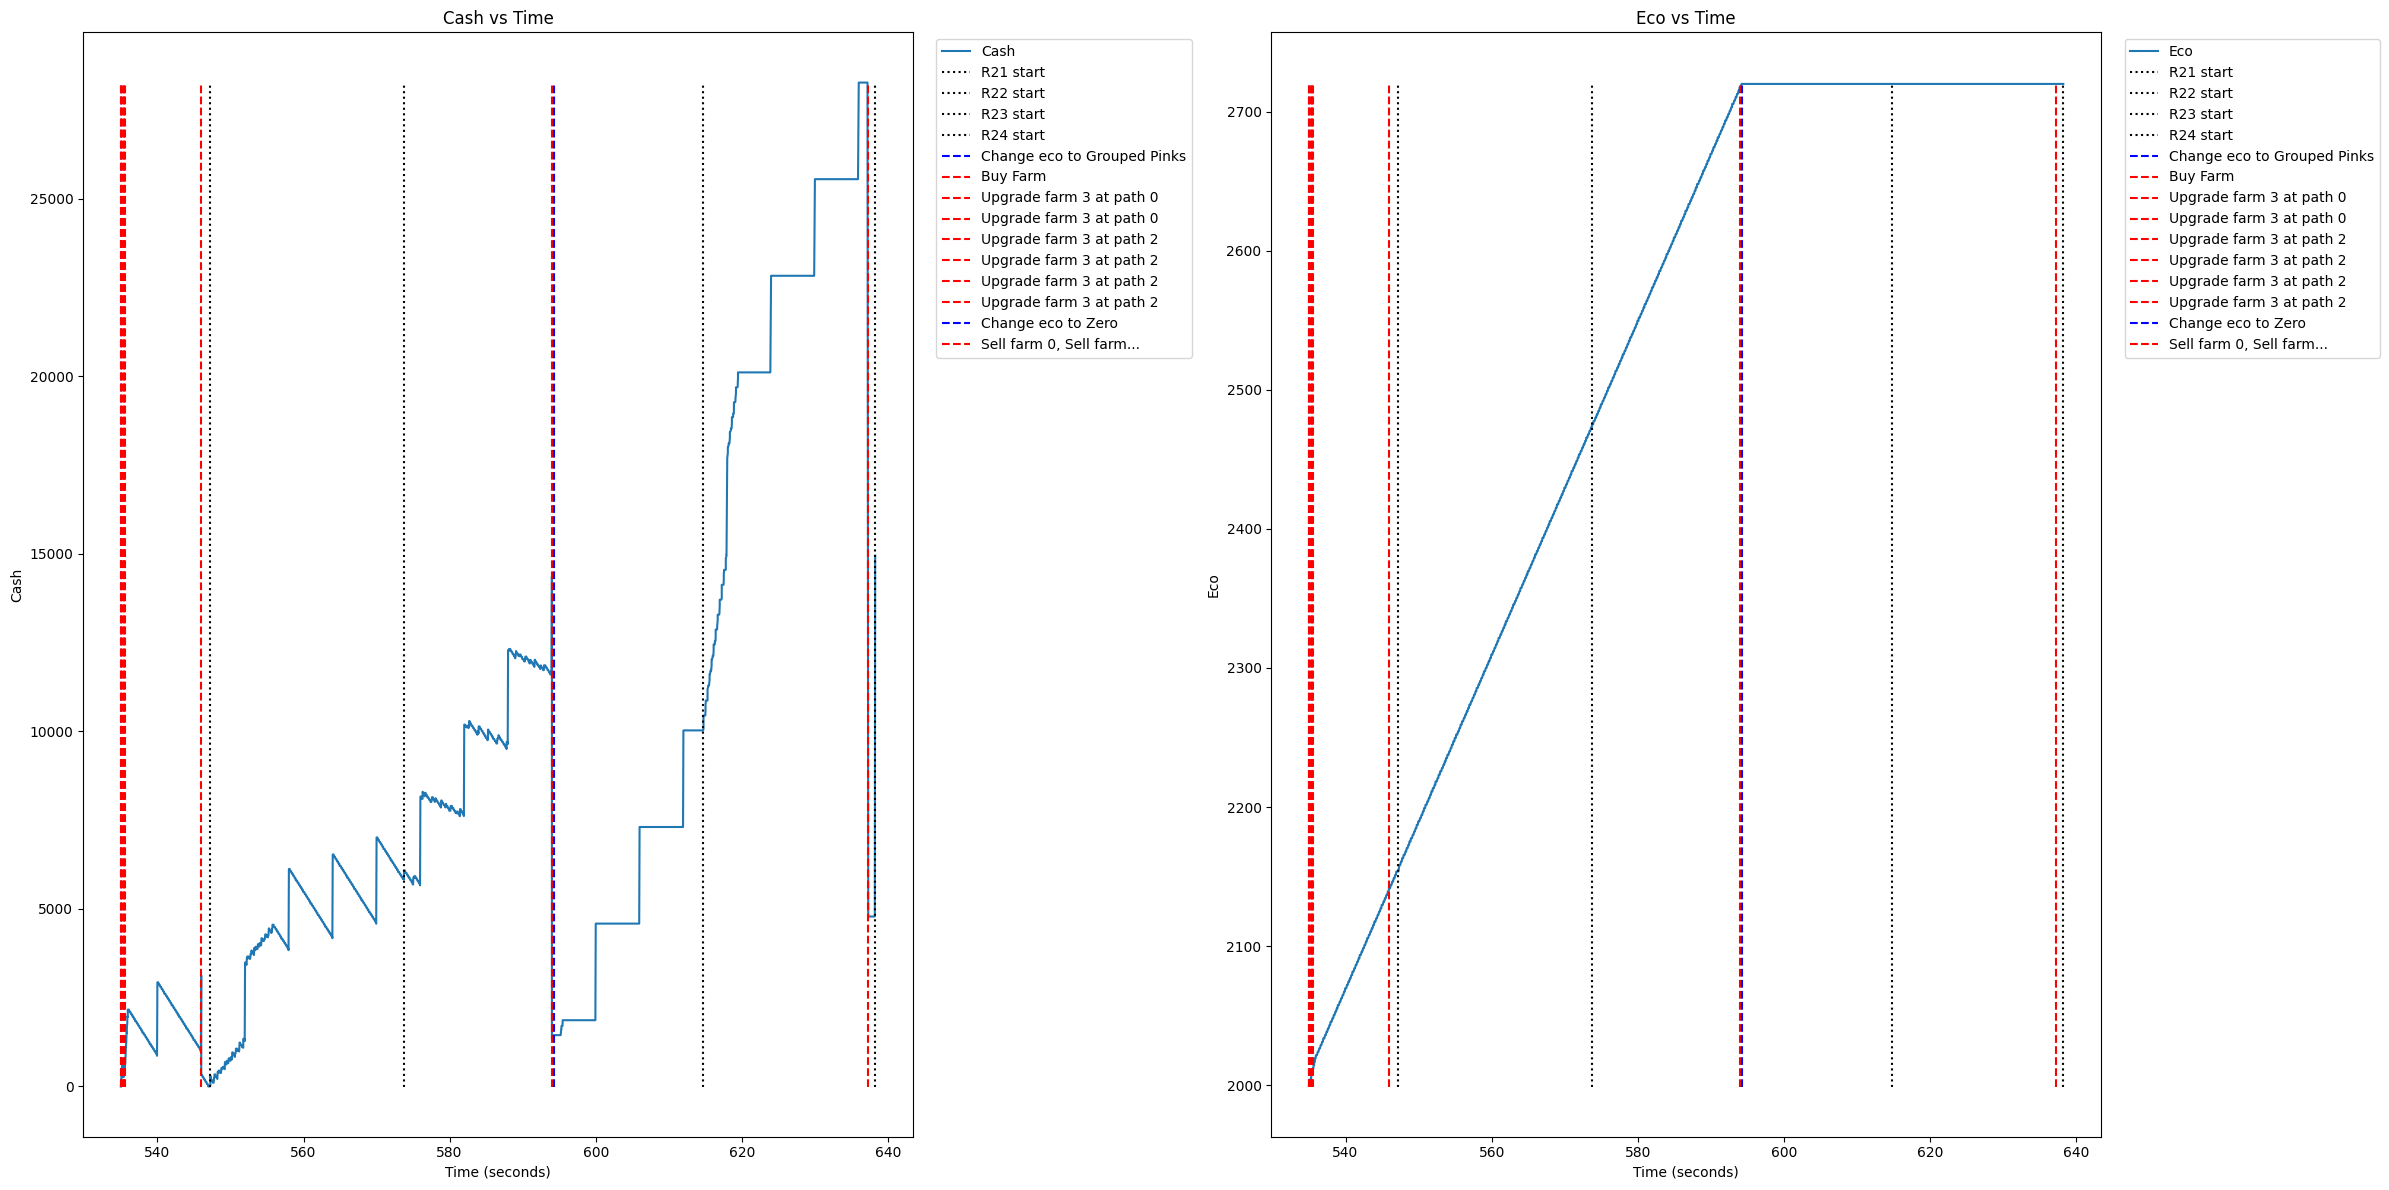

In [5]:
initial_state_game = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': b2.ecoSend(send_name='Grouped Pinks'),
    'Rounds': rounds,
    'Game Round': 20,
    'Farms': farms,
    'Buy Queue': copy.deepcopy(buy_queue),
    'Eco Queue': copy.deepcopy(eco_queue)
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 24)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'mws_flowchart')

# Optimizing the Farm Flowchart for R26 (Advanced)

We determine the optimal time to stop pink eco'ing during a midgame farm scenario. To this end, assume that we have access to 1 x 420 farms on R20 with some amount of eco. For our farming flowchart, we precommit to the following sequence of purchases and sells:

| Order |  Transactions  |
|-------|----------------|
| 1     | Buy 204 farm (index 1) |
| 2     | Sell 420 farm (index 0), upgrade to 205 farm (index 1) |
| 3     | Buy 420 farm (index 2) |
| 4     | Buy 204 farm (index 3) |
| 5     | Sell 204 farm (index 3) into 520 Farm (index 2) |

Some comments before proceeding to the simulation:

1. The decision concerning when to stop eco for this simulation will in general be influenced by how much eco we have at the simulation start. The user is encouraged to input different values for eco to see how they influence the optimal stopping time. In this case, I'm going to assume a starting eco of $1250$. 
2. When using the simulator to map out complex farming flowcharts, you should write down what index is assigned to each farm. In this case, the farm that we will start with, the $420$ farm, has index $0$, since it's the first farm. The 1st 204 farm that we buy has index $1$ (it's a new farm, and index $0$ was already taken). In the table above, I've written out all the indexes for this example.

Before we set the initial game state, let's define our initial farms and also the buy queue:

In [6]:
farms = [
    b2.initFarm(rounds.getRoundFromTime(19.99),[4,2,0])
]

buy_queue = [

    #Purchase a 204 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],
    [b2.upgradeFarm(1,2)],

    #As soon as we have the money, sell the 420 farm & purhcase a 205 farm
    [b2.sellFarm(0), b2.upgradeFarm(1,2)],

    #Purchase a 420 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,0)],
    [b2.upgradeFarm(2,1)],
    [b2.upgradeFarm(2,1)],
    [b2.upgradeFarm(2,0)],

    #Purchase a 204 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,0)],
    [b2.upgradeFarm(3,1)],
    [b2.upgradeFarm(3,1)],
    [b2.upgradeFarm(3,0)]
]

## Round 26 Drained Druid Sub Farm (IMF Loans)

In a drain game, the win condition for druid sub farm may come down to whether or not the player can afford superstorm or not. We assume the player has a 205 MWS up before R25 and intends to purchase and use an IMF Loan to fund superstorm.

In [7]:
rounds = b2.Rounds(0.5)

farms = [
    b2.initFarm(rounds.getTimeFromRound(24.9), upgrades = [2,0,5])
]


In the simulator, each farm is assigned a unique "key" corresponding (ordinally) to when it was purchased. The first farm created in the simulation is assigned `0`, the second one `1`, and so forth. For this example, we want to try to upgrade farm `1` into an IMF Loan. Importantly, when using IMF Loans to fund extremely expensive upgrades, we want to take the following actions in the exact order:
1. Withdraw from the IMF
2. Take out a loan from the IMF
3. Sell the IMF
4. Buy Defense

You'll notice that I grouped these into one single item within the buy queue. The reason for this is that I want to wait until the last possible moment to withdraw from the bank and use the loan to maximize the amount taken out from the bank and to minimize the damage done from taking on debt. On the other hand, it is useful for me to buy each upgrade to the 240 farm as soon as I can do so (rather than waiting to buy everything at once), so I can maximize my income from this farm.

In [8]:
buy_queue = [

    #Buy a 240 farm
    [b2.buyFarm()],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,0)],
    [b2.upgradeFarm(1,1)],
    [b2.upgradeFarm(1,1)],
    [b2.upgradeFarm(1,1)],
    [b2.upgradeFarm(1,1)],

    #As soon as the loan can be taken out, withdraw money from the IMF Loan, take out an IMF Loan, sell the IMF Loan bank, and purchase Superstorm
    [b2.withdrawBank(1), b2.activateIMF(1), b2.sellFarm(1), b2.buyDefense(65000)]
]

,Revenue,Expenses,Profit,Eco Impact
Farm Index,,,,
0,14240.0,0,14240.0,1247.0
1,26290.0,15600,10690.0,3252.0


The current cash and eco are (6130.0,1600)


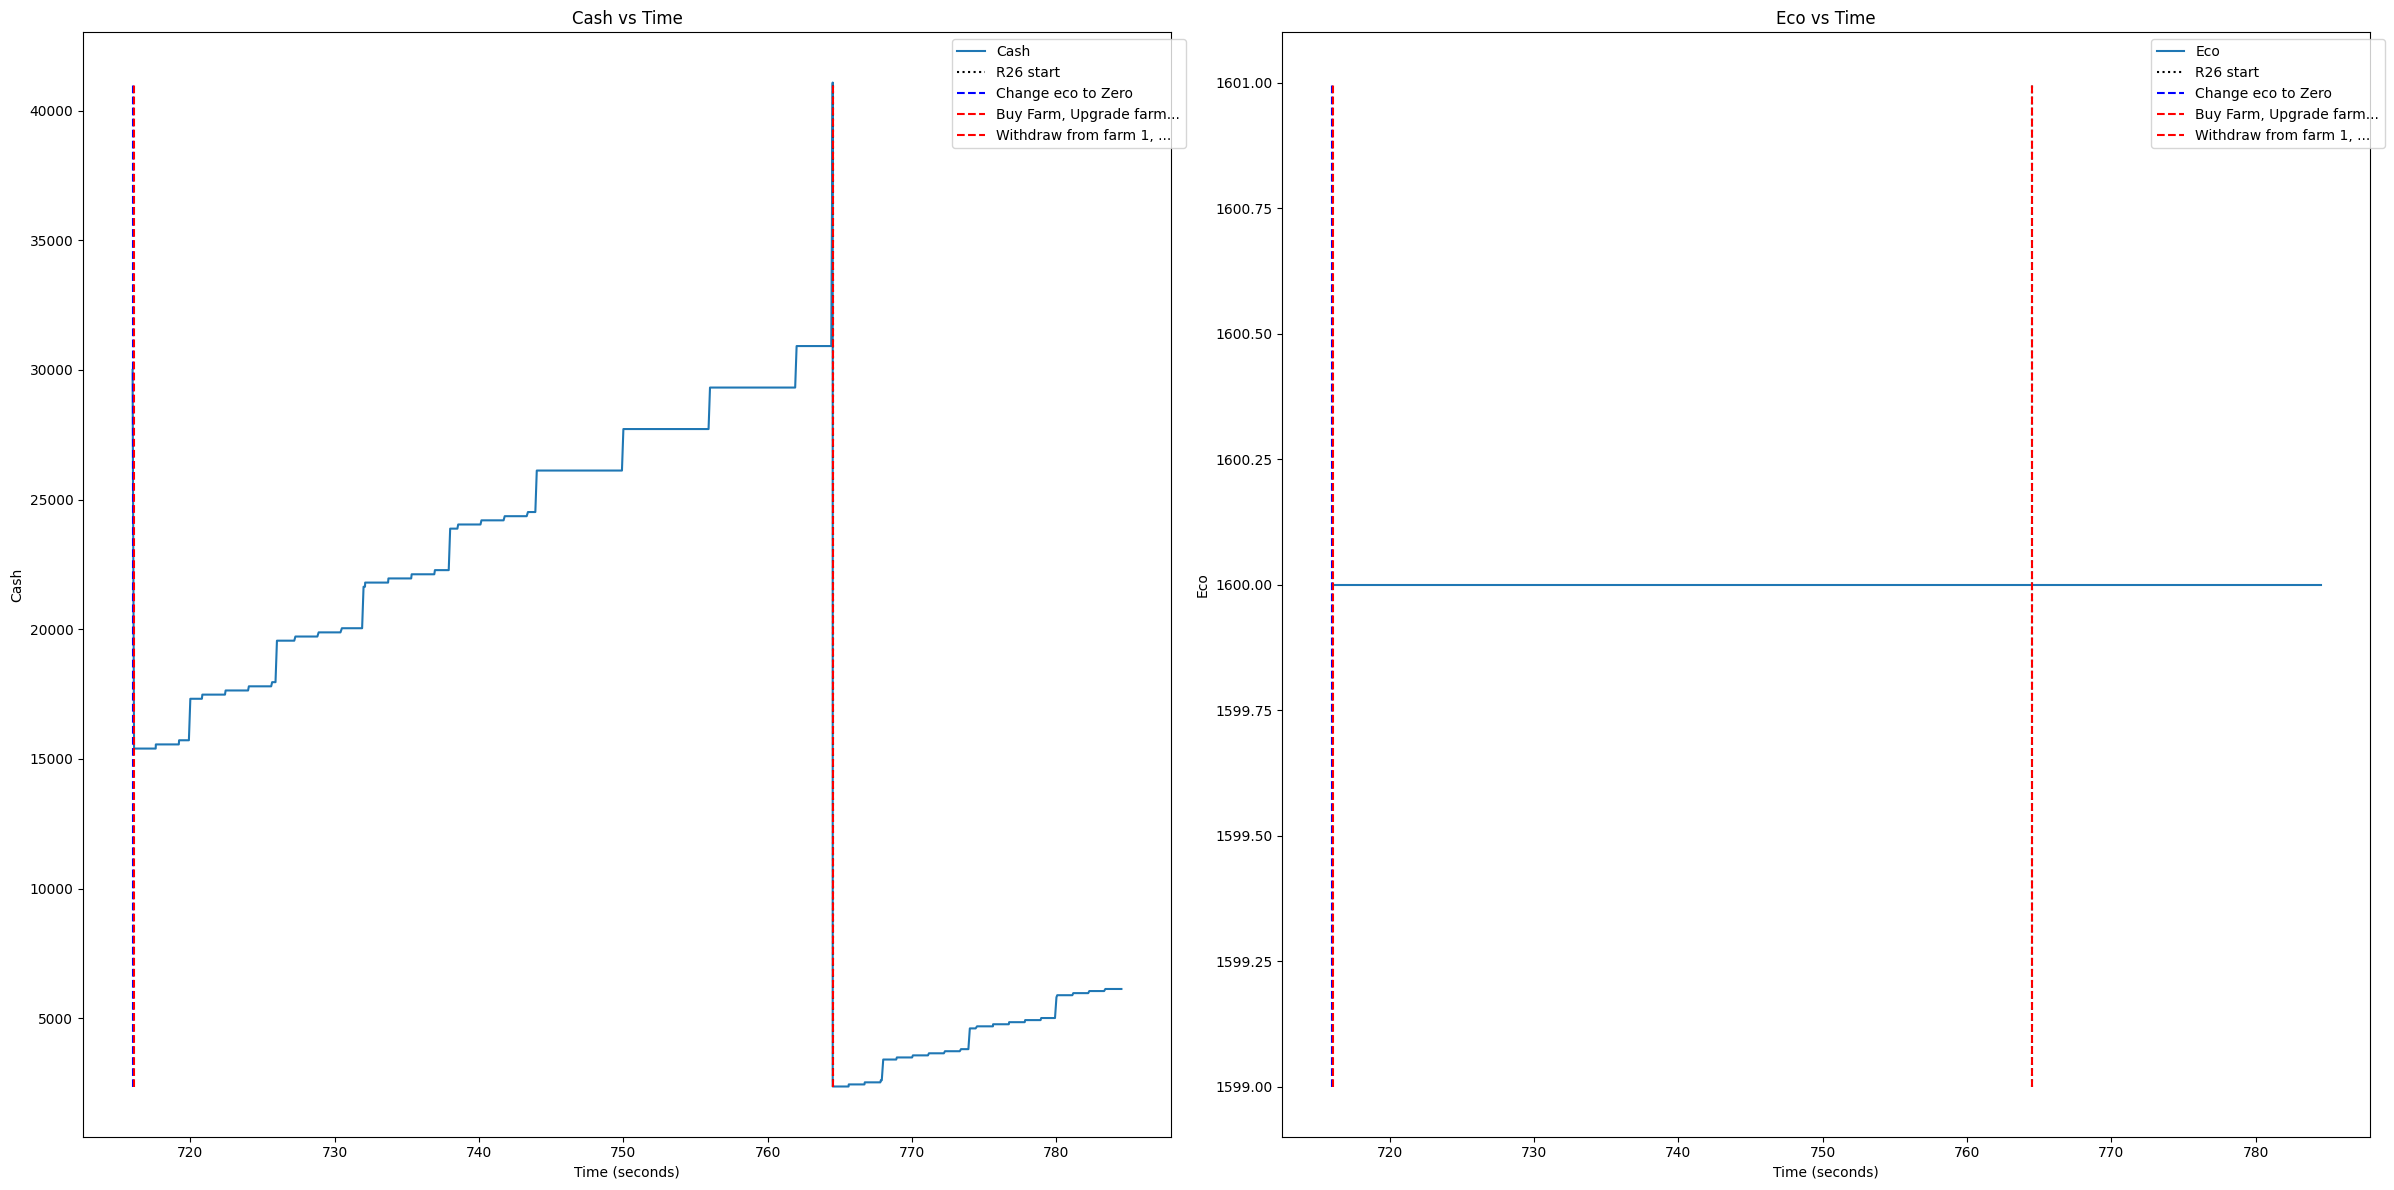

In [9]:
initial_state_game = {
    'Cash': 30000,
    'Eco': 1600,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Rounds': rounds,
    'Game Round': 25,
    'Farms': farms,
    'Buy Queue': copy.deepcopy(buy_queue)
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 26.5)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'druid_sub_farm')